# Case Study: Zeeguu/API
- Backend of a web application that supports [free reading in foreign languages](https://zeeguu.org)
- Open source [repository on GH](https://github.com/zeeguu/API/)

# Basic Data Gathering

- extracting basic dependencies between python modules
- every .py file is called a module in Python
- direct relationship between file name and module name
  - file: `./zeeguu_core/model/user.py` <==>
  - module: `zeeguu_core.model.User`




In [33]:
# Installing Required Dependencies
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis

You should consider upgrading via the '/Users/nicklasjeppesen/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/nicklasjeppesen/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


In [34]:
# In Collab our notebook runs in a temporary mounted file system
# Let's print the name of the folder where our script runs

import os
cwd = os.getcwd()
print(cwd)


/Users/nicklasjeppesen/Desktop/zeep


In [35]:
# Let's declare a var for the path where we're going to download a repository
# Warning: this must end in /
CODE_ROOT_FOLDER=cwd+"/content/zeeguu-api/"


In [36]:
from git import Repo
# GitPython is a library that allows us to work easily with git from Python
# https://gitpython.readthedocs.io/en/stable/tutorial.html


# If the file exists, it means we've already downloaded
#if not os.path.exists(CODE_ROOT_FOLDER):
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)


In [37]:
os.path.exists("/Users/nicklasjeppesen/Desktop/zeep/content/zeeguu-api/")

True

In [38]:
print(CODE_ROOT_FOLDER)

/Users/nicklasjeppesen/Desktop/zeep/content/zeeguu-api/


In [39]:
# helper function to get a file path w/o having to always provide the /content/zeeguu-api/ prefix
def file_path(file_name):
    return CODE_ROOT_FOLDER+file_name

assert (file_path("zeeguu/core/model/user.py") == cwd+"/content/zeeguu-api/zeeguu/core/model/user.py")


In [40]:
# extracting a module name from a file name
def module_name_from_file_path(full_path):

    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert 'zeeguu.core.model.user' == module_name_from_file_path(file_path('zeeguu/core/model/user.py'))

In [41]:
# naïve way of extracting imports using regular expressions
import re


# we assume that imports are always at the
# TODO for you: add full support for imports; this is not complete...
def import_from_line(line):

    # regex patterns used
    #   ^  - beginning of line
    #   \S - anything that is not space
    #   +  - at least one occurrence of previous
    #  ( ) - capture group (read more at: https://pynative.com/python-regex-capturing-groups/)
    try:
      y = re.search("^from (\S+)", line)
      if not y:
        y = re.search("^import (\S+)", line)
      return y.group(1)
    except:
      return None


# extracts all the imported modules from a file
# returns a module of the form zeeguu_core.model.bookmark, e.g.
def imports_from_file(file):

    all_imports = []

    lines = [line for line in open(file)]

    for line in lines:
        imp = import_from_line(line)

        if imp:
            all_imports.append(imp)

    return all_imports

imports_from_file(file_path('/zeeguu/core/model/user.py'))

['datetime',
 'json',
 'random',
 're',
 'sqlalchemy.orm',
 'zeeguu.core',
 'sqlalchemy',
 'sqlalchemy.orm',
 'sqlalchemy.orm.exc',
 'zeeguu.core.language.difficulty_estimator_factory',
 'zeeguu.core.model',
 'zeeguu.logging',
 'zeeguu.core.util',
 'zeeguu.core.model',
 'zeeguu.logging']

In [49]:
import ast

f = open(cwd+"/content/zeeguu-api/zeeguu/core/model/user.py")
user_ast = ast.parse(f.read())
print(user_ast.body[0])  
print(user_ast.body[1])  



In [50]:
# test
print(imports_from_file(file_path('zeeguu/core/model/bookmark.py')))
#print(imports_from_file(file_path('zeeguu/core/model/unique_code.py')))

['datetime', 'sqlalchemy', 'sqlalchemy', 'sqlalchemy.orm', 'sqlalchemy.orm.exc', 'wordstats', 'zeeguu.logging', 'zeeguu.core.bookmark_quality.fit_for_study', 'zeeguu.core.definition_of_learned', 'zeeguu.core.model', 'zeeguu.core.model.sorted_exercise_log', 'zeeguu.core.model.exercise', 'zeeguu.core.model.exercise_outcome', 'zeeguu.core.model.exercise_source', 'zeeguu.core.model.language', 'zeeguu.core.model.text', 'zeeguu.core.model.user', 'zeeguu.core.model.user_word', 'zeeguu.core.util.encoding', 'zeeguu', 'zeeguu.core.model']


# Now we extract the dependencies between all the files

To do that we iterate over all the python files with the help of the `Path.rglob` function from `pathlib`

And we create a network with the help of the `networkx` package.

In [44]:
import pathlib
from pathlib import Path
import networkx as nx

def dependencies_graph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.Graph()

    for file in files:
        file_path = str(file)

        module_name = module_name_from_file_path(file_path)

        if module_name not in G.nodes:
            G.add_node(module_name)

        for each in imports_from_file(file_path):
            G.add_edge(module_name, each)

    return G

# Mathplotlib also has support for drawing networks

We do a simple drawing of all the files and their dependencies in our system

In [45]:
import matplotlib.pyplot as plt

# a function to draw a graph
def draw_graph(G, size, **args):
    plt.figure(figsize=size)
    nx.draw(G, **args)
    plt.show()

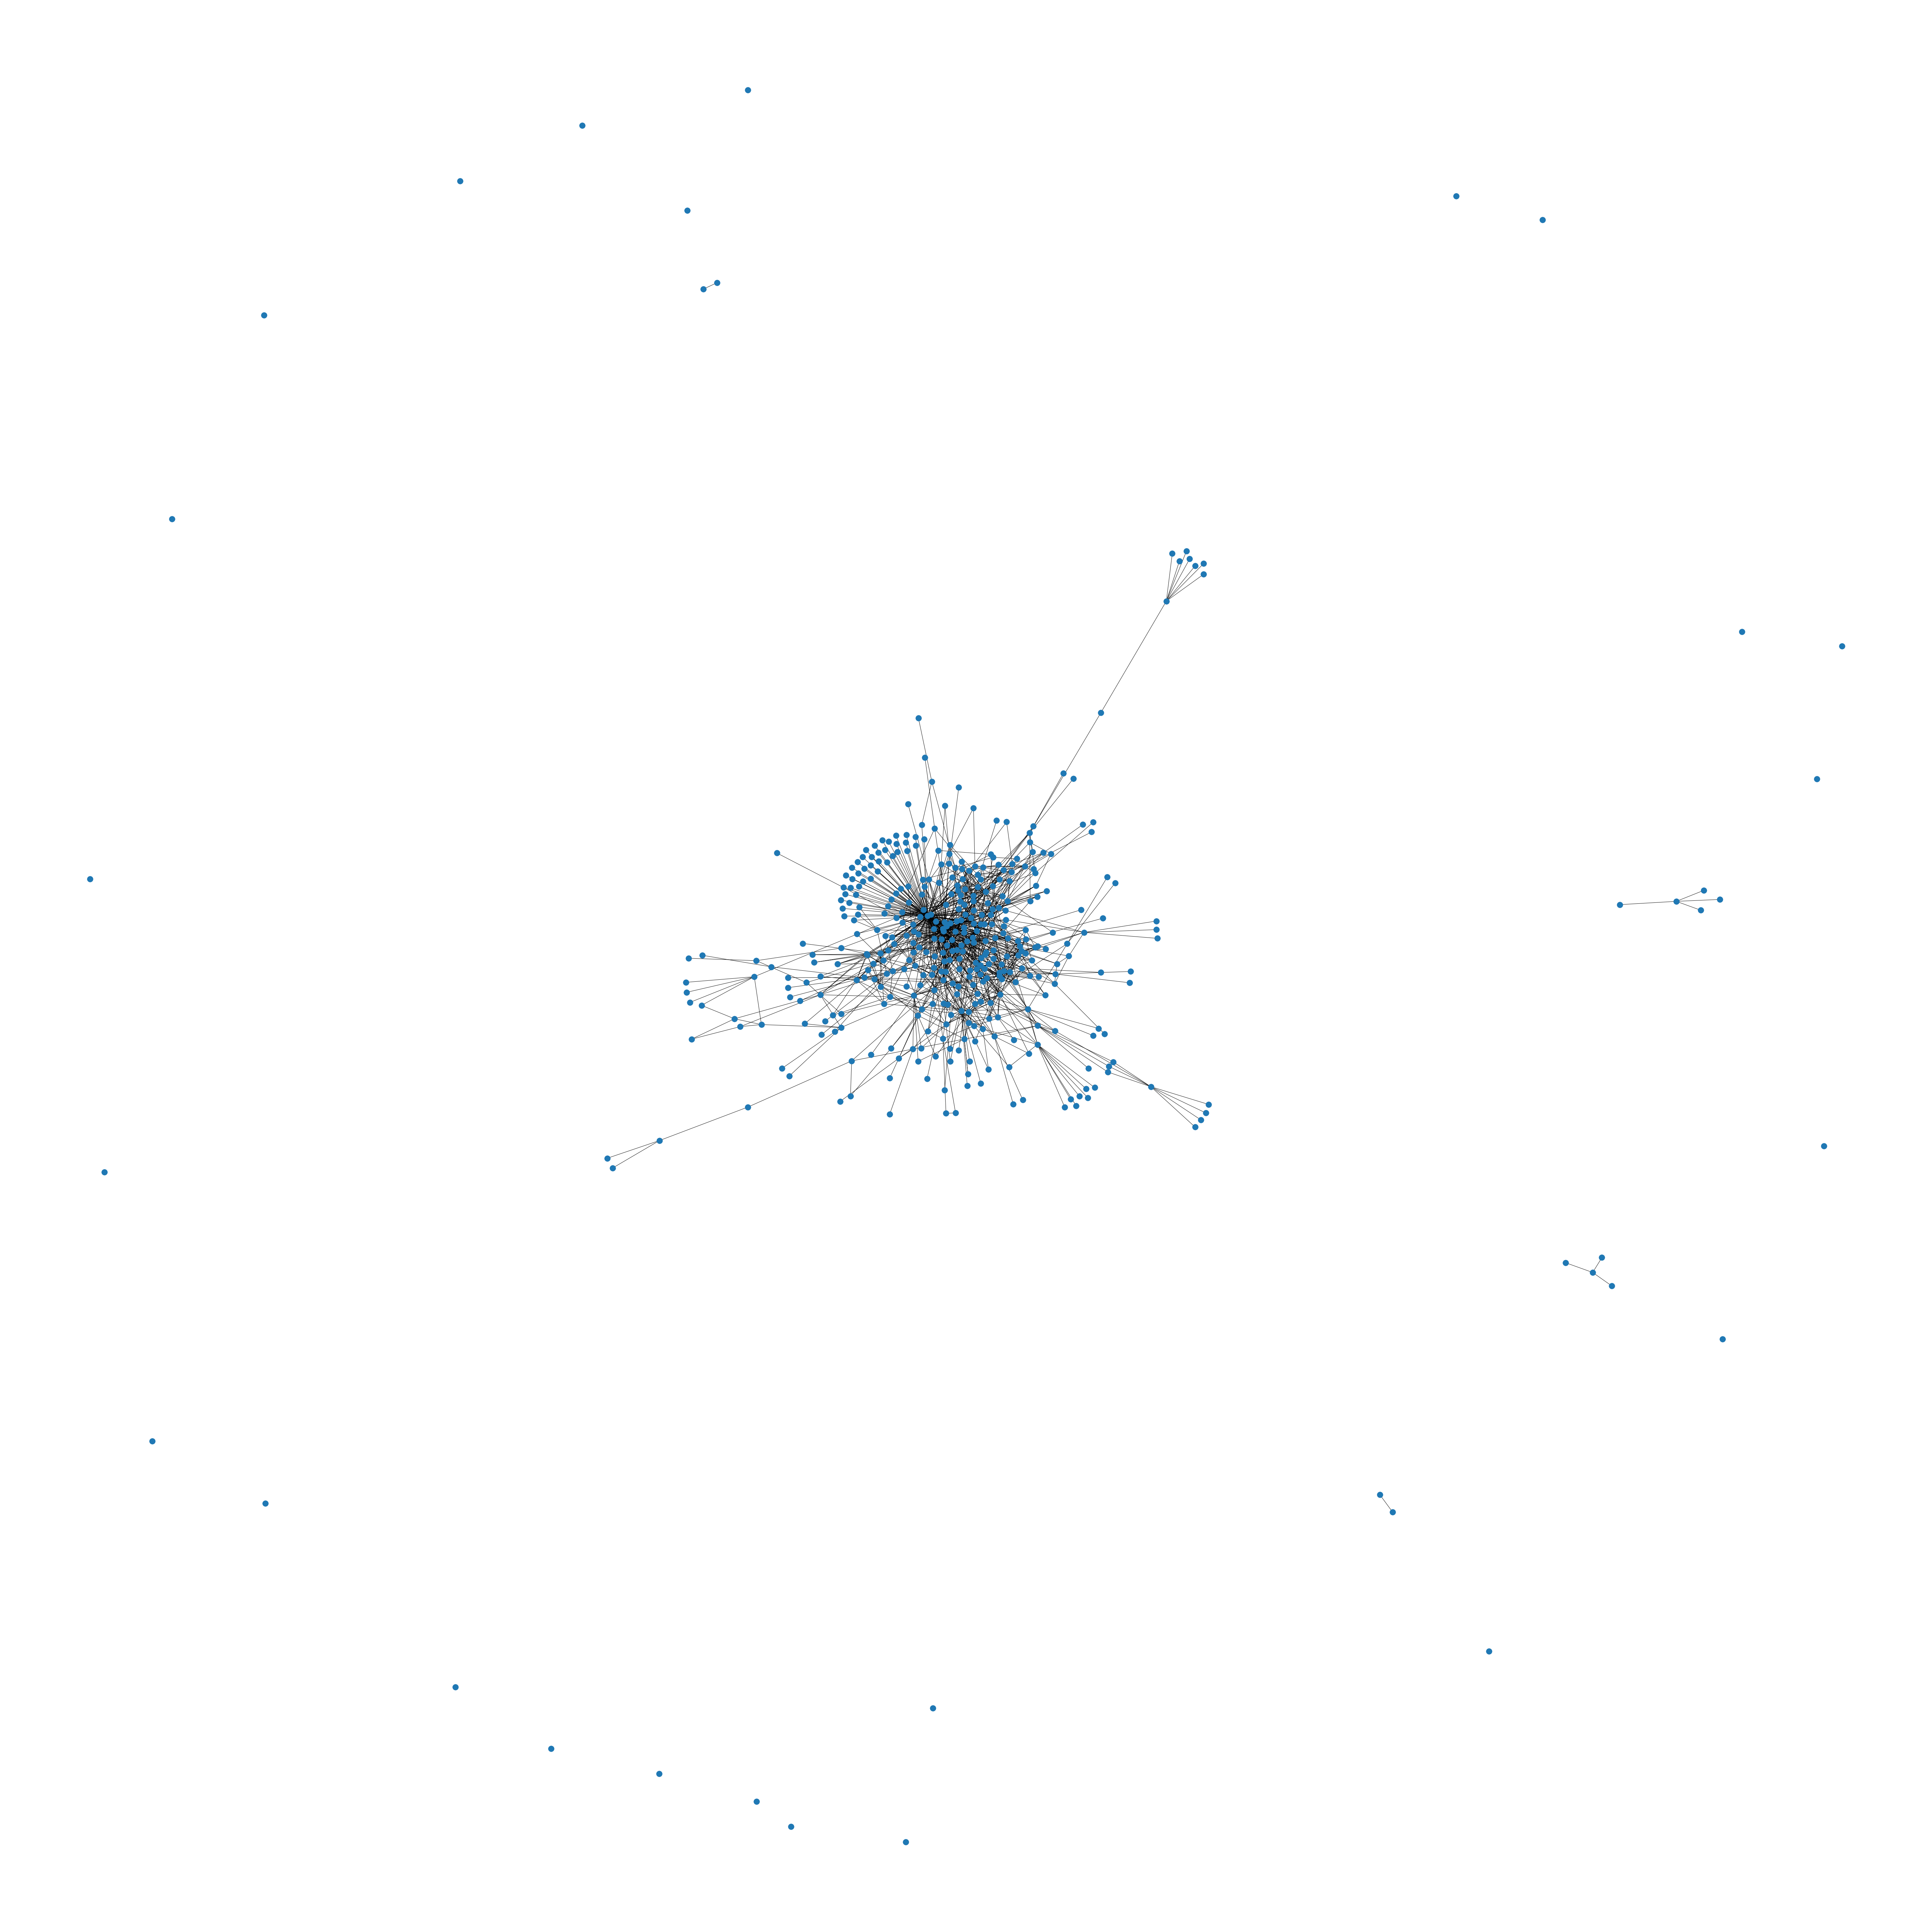

In [46]:
G = dependencies_graph(CODE_ROOT_FOLDER)
draw_graph(G, (80,80), with_labels=False)

In [47]:
# However, if we think a bit more about it, we realize tat a dependency graph
# is a directed graph (e.g. module A depends on m)
# with any kinds of graph either directed (nx.DiGraph) or
# non-directed (nx.Graph)

def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)

        if source_module not in G.nodes:
            G.add_node(source_module)

        for target_module in imports_from_file(file_path):

            G.add_edge(source_module, target_module)
            # print(module_name + "=>" + each + ".")

    return G


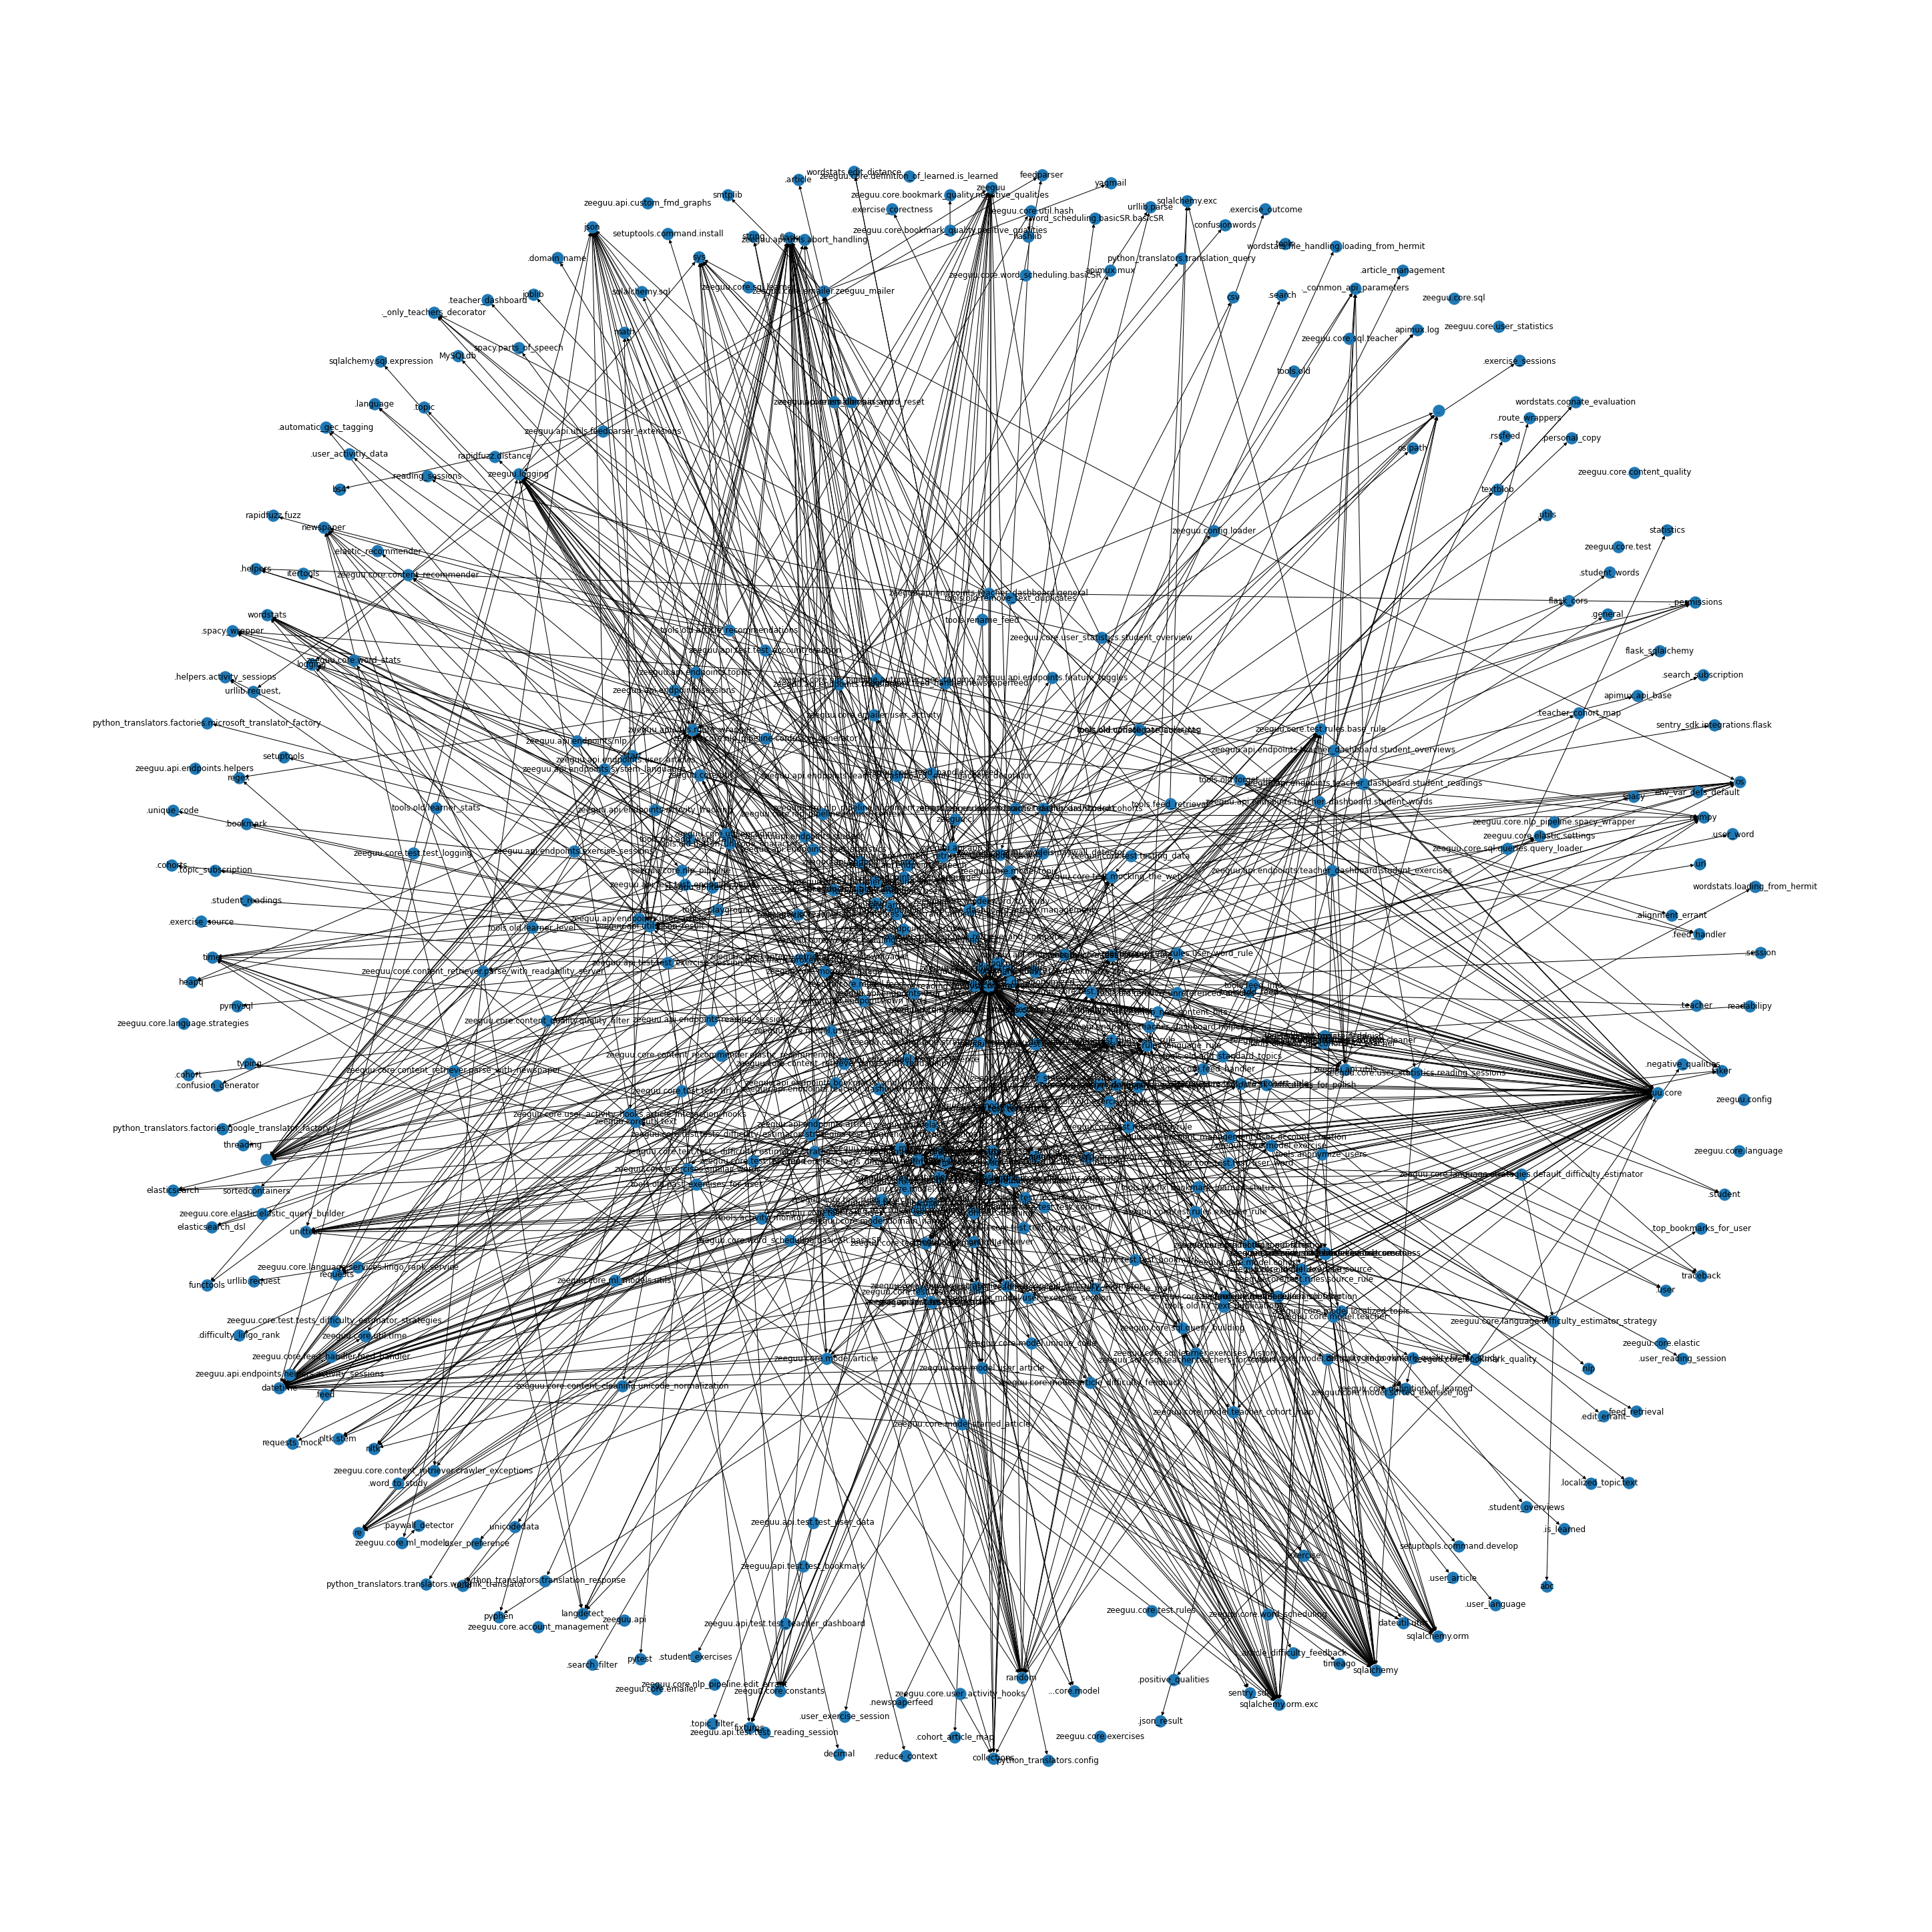

In [48]:
# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)
draw_graph(DG, (40,40), with_labels=True)